In [1]:
import numpy as np
import pandas as pd
from scipy import fftpack
from scipy import signal
import time
import os
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
import pylab
import pickle
import copy
import processing
import matplotlib.animation as animation
import datetime
import multiprocessing as mp
import processing

%matplotlib inline

共通変数をここに定義

In [2]:
DataName='sensor5_AccXYZ'
SensorName='sensor5'
Axis='AccXYZ'
SampleNum=16
width=3000

In [3]:
WORKSPACE_PATH = '/home/takeyama/pywork/ipython/2016-07-11'

StudyDataPath=WORKSPACE_PATH+'/Study/'+DataName+'/'
if not os.path.exists(StudyDataPath): os.makedirs(StudyDataPath)

GlaphDataPath=WORKSPACE_PATH+'/Graph/'+DataName+'/power/'
if not os.path.exists(GlaphDataPath): os.makedirs(GlaphDataPath)

StudyDataModelPicPath=WORKSPACE_PATH+'/Study/'+DataName+'/modelPic/'
if not os.path.exists(StudyDataModelPicPath): os.makedirs(StudyDataModelPicPath)

WindowDataPath=WORKSPACE_PATH+'/window/'
RawDataPath=WORKSPACE_PATH+'/raw/'

In [4]:
"""
    encordData,decordData
    firstNum:
    goalNum:
    commonLabel:共通名前
"""
def MakeGlaph(encordData,decordData,firstNum,goalNum,commonLabel):
    eRow, eCol=encordData.shape
    dRow, dCol=decordData.shape
    
    if eRow!=dRow | eCol!=dCol:
        return -1
    start = firstNum
    goal=goalNum
    print str(start)+' is start '+str(goal)+' is goal'
    dataE = encordData.reshape(eRow*eCol,1)[start:goal]
    dataD = decordData.reshape(dRow*dCol,1)[start:goal]
    plt.clf() 
    plt.figure(figsize=(100,50))
    plt.plot(range(0,len(dataE)),dataE,'--r',label="raw data")
    plt.plot(range(0,len(dataD)),dataD,'b',label="reconstruct")
    plt.legend(loc='best')
    plt.title(str(start)+"-"+str(goal))
    plt.savefig(commonLabel+'-'+str(start)+"-"+str(goal)+'-'+'glaph')
    plt.clf()
    plt.cla()
    plt.close('all')
    return 1

すべてのデータを読みdし、グラフ化する

並列処理でグラフを作成する

Graph range=0 : 3000
Graph range=3000 : 6000
Graph range=6000 : 9000
Graph range=9000 : 12000
Graph range=12000 : 15000
Graph range=0 : 3000
Graph range=3000 : 6000
Graph range=6000 : 9000
Graph range=9000 : 12000
Graph range=12000 : 15000
Graph range=0 : 3000
Graph range=3000 : 6000
Graph range=6000 : 9000
Graph range=9000 : 12000
Graph range=12000 : 15000
Graph range=0 : 3000
Graph range=3000 : 6000
Graph range=6000 : 9000
Graph range=9000 : 12000
Graph range=12000 : 15000
Graph range=0 : 3000
Graph range=3000 : 6000
Graph range=6000 : 9000
Graph range=9000 : 12000
Graph range=12000 : 15000
Graph range=0 : 3000
Graph range=3000 : 6000
Graph range=6000 : 9000
Graph range=9000 : 12000
Graph range=12000 : 15000
Graph range=0 : 3000
Graph range=3000 : 6000
Graph range=6000 : 9000
Graph range=9000 : 12000
Graph range=12000 : 15000
Graph range=0 : 3000
Graph range=3000 : 6000
Graph range=6000 : 9000
Graph range=9000 : 12000
Graph range=12000 : 15000
Graph range=0 : 3000
Graph range=3000 : 

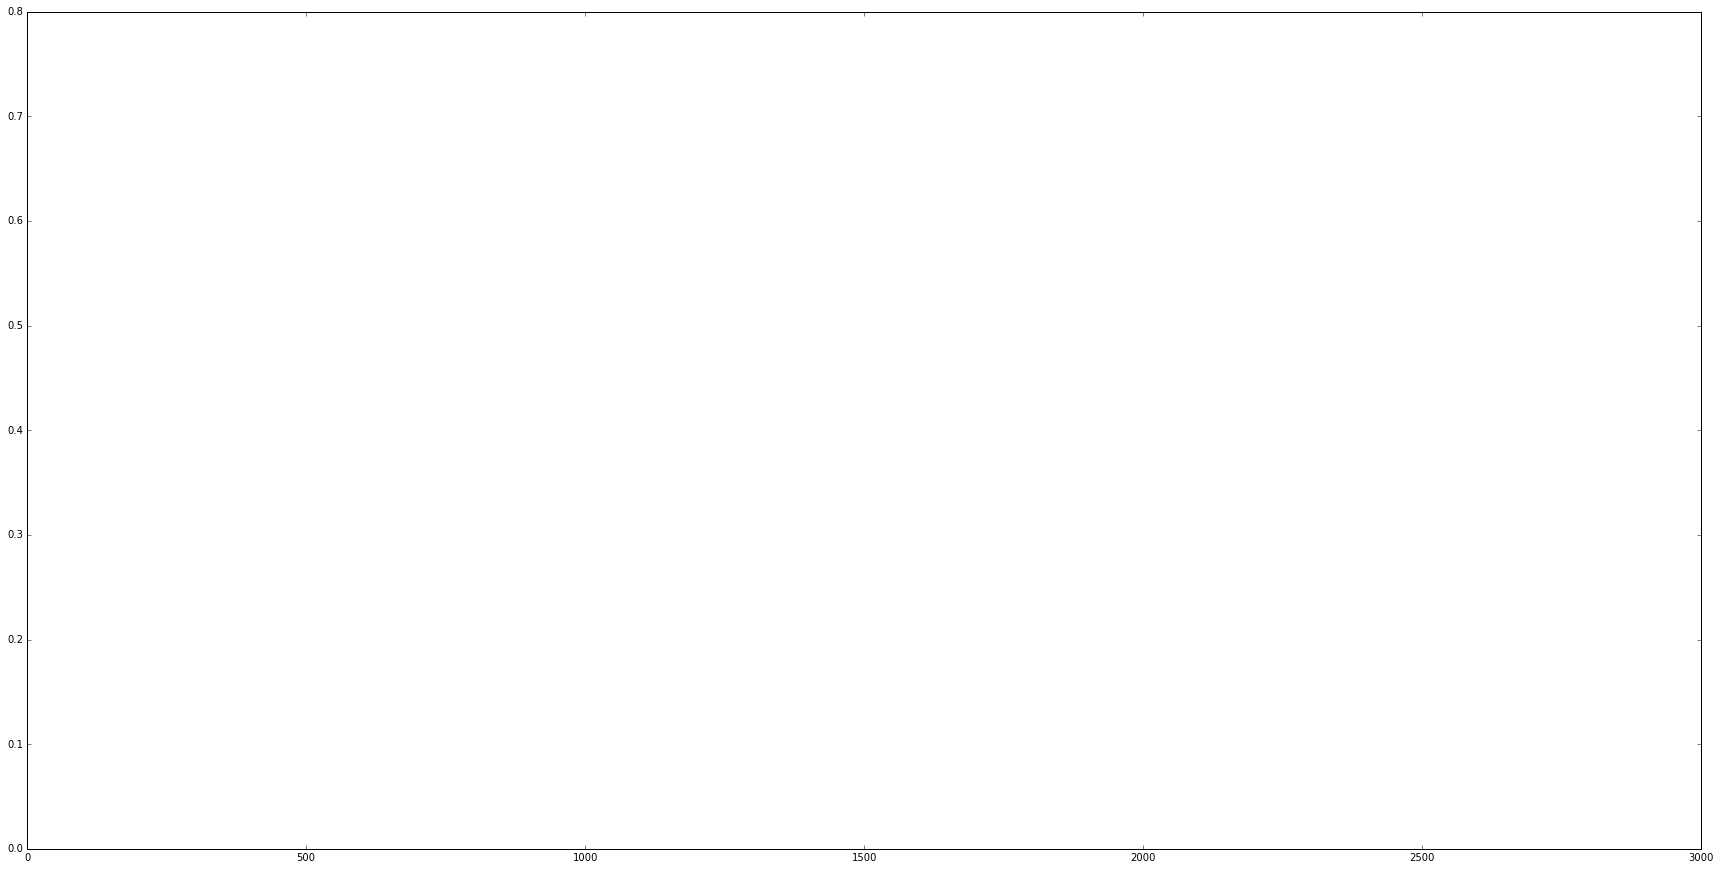

In [5]:
# define SaveFileName
# 8, 4, 12, 16, 32, 64
# 32 floats -> compression of factor 24.5, assuming the input is 784 floats
AllEncoding_dim = [4, 8, 12, 16, 32, 64]  
window = processing.LoadDicDataFromFileNPZ(WindowDataPath+SensorName+'_'+Axis+'_train_edim=8.npz')
rows,colms=window.shape
window = window.reshape(rows,colms/3,3)
width = 3000
fig = plt.figure(figsize=(30,15))
ax = fig.add_subplot(111)

AllWindow = [window[:,:,0],window[:,:,1],window[:,:,2]]
WindowName=['AccX','AccY','AccZ']

for rawData,name in zip(AllWindow,WindowName):
    for encoding_dim in AllEncoding_dim:
        SaveFileNameDecord=DataName+'_decoded'+'_edim='+str(encoding_dim)
        SaveFileNameGraph=GlaphDataPath+ DataName+'_edim='+str(encoding_dim)

        reconstructData = processing.LoadDicDataFromFileNPZ(StudyDataPath+SaveFileNameDecord)

        # FFT 
        fftDataE = np.array([])
        fftDataD = np.array([])
        for i in range(len(window)):
            fftDataE=np.append(fftDataE, fftpack.fft( rawData[i])[1:(SampleNum/2)+1])
            fftDataD=np.append(fftDataD, fftpack.fft( reconstructData[i])[1:(SampleNum/2)+1])
        fftDataE = fftDataE.reshape(len(fftDataE)/(SampleNum/2),(SampleNum/2))
        fftDataD = fftDataD.reshape(len(fftDataD)/(SampleNum/2),(SampleNum/2))
        processing.SaveDicDataFromFileNPZ(StudyDataPath, DataName+'_edim='+str(encoding_dim)+'-'+name+'-fft-raw',fftDataE)
        processing.SaveDicDataFromFileNPZ(StudyDataPath, DataName+'_edim='+str(encoding_dim)+'-'+name+'-fft-restruct',fftDataD)
    
        # Power
        PowerDataE = np.imag(fftDataE)**2+np.real(fftDataE)**2
        PowerDataD = np.imag(fftDataD)**2+np.real(fftDataD)**2
        processing.SaveDicDataFromFileNPZ(StudyDataPath, DataName+'_edim='+str(encoding_dim)+'-'+name+'-power-raw',PowerDataE)
        processing.SaveDicDataFromFileNPZ(StudyDataPath, DataName+'_edim='+str(encoding_dim)+'-'+name+'-power-restruct',PowerDataD)
       
        # FFT plot
        for freq in range(len(fftDataE[0])):
            for i in range(width,fftDataE.shape[0],width):
                start =i-width 
                goal=i

                dataE = PowerDataE[start:goal,freq]
                dataD = PowerDataD[start:goal,freq]

                #dataE,dataDをPower
                ax.plot(range(0,len(dataE)),dataE,'r',label="train data")
                ax.plot(range(0,len(dataD)),dataD,'b',label="reconstruct")
                ax.legend(loc='best')
                ax.set_title(str(start)+"-"+str(goal))
                ax.figure.savefig(SaveFileNameGraph+'-'+name+'-'+str(start)+"-"+str(goal)+'-'+'No-'+str(freq)+'-glaph')
                ax.clear()
                print 'Graph range='+str(start)+' : '+str(goal)
                time.sleep(3)

In [6]:
window.size

764208

In [7]:
fftDataD.shape

(15921, 8)